In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt

### MRI Images

In [2]:
df_mri = pd.read_csv("./Key_MRI_30Nov2025.csv")

# Ensure  image_date in datetime format
df_mri["image_date"] = pd.to_datetime(df_mri["image_date"])


In [3]:
df_mri.columns

Index(['image_id', 'subject_id', 'image_visit', 'image_date', 'series_type',
       'mri_protocol_phase', 'series_description', 'acceleration',
       'acquisition_type', 'acquisition_plane', 'number_volumes',
       'slices_per_volume', 'slice_thickness', 'scanner_manufacturer',
       'scanner_model', 'software_version', 'magnetic_field_strength',
       'receive_coil_name', 'study_instance_uid', 'series_instance_uid',
       'loni_study', 'loni_series', 'loni_image'],
      dtype='object')

In [4]:
# Filter for 3T
df_mri = df_mri[ df_mri["magnetic_field_strength"] == 3]
print(len(df_mri))

# Filter for T1 weighted
df_mri = df_mri[ df_mri["series_type"] == "T1w"]
print(len(df_mri))

# Filter for 3d 
df_mri = df_mri[ df_mri["acquisition_type"] == "3D"]
print(len(df_mri))


81050
14470
14286


In [5]:
df_mri["subject_id"].unique()

array(['002_S_0413', '002_S_0559', '002_S_0729', ..., '135_S_10204',
       '082_S_10155', '005_S_10205'], shape=(2682,), dtype=object)

### PET Images

In [6]:
df_pet = pd.read_csv("./Key_PET_06Dec2025.csv")

# Ensure image_date is in datetime format
df_pet["image_date"] = pd.to_datetime(df_pet["image_date"])

print(len(df_pet))

9980


In [7]:
# Filter for Amyloid PET
df_pet = df_pet[ (df_pet['amyloid_pet'] == "Y") | 
        (df_pet['radiopharmaceutical'].isin(['11C-PIB', '18F-AV45', '18F-FBB']))]


print(len(df_pet))

4859


In [8]:
# Filter MRI scans for patients who have PET scans
pet_patients = df_pet["subject_id"].unique().tolist()

print(len(pet_patients))
df_mri = df_mri[ df_mri["subject_id"].isin(pet_patients) ]
len(df_mri)


2241


12104

### Add diagnoses

In [9]:

# Read diagnostic summary
df_diagnostic = pd.read_csv("./DXSUM_13Aug2025.csv")

# Ensure EXAMDATE has datetime format
df_diagnostic["EXAMDATE"] = pd.to_datetime(df_diagnostic["EXAMDATE"])

df_diagnostic.head()

,PHASE,PTID,RID,VISCODE,VISCODE2,EXAMDATE,DIAGNOSIS,DXNORM,DXNODEP,DXMCI,...,DXODES,DXCONFID,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0002,2,bl,bl,2005-09-29,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,2,107,2005-10-01,NaN,NaN,NaN,NaN,2005-10-01 00:00:00.0
1,ADNI1,011_S_0003,3,bl,bl,2005-09-30,3.0,-4.0,-4.0,-4.0,...,-4.0,3.0,4,107,2005-10-01,NaN,NaN,NaN,NaN,2005-10-01 00:00:00.0
2,ADNI1,011_S_0005,5,bl,bl,2005-09-30,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,6,107,2005-10-01,NaN,NaN,NaN,NaN,2005-10-01 00:00:00.0
3,ADNI1,011_S_0008,8,bl,bl,2005-09-30,1.0,1.0,-4.0,-4.0,...,-4.0,3.0,8,107,2005-10-01,NaN,NaN,NaN,NaN,2005-10-01 00:00:00.0
4,ADNI1,022_S_0007,7,bl,bl,2005-10-06,3.0,-4.0,-4.0,-4.0,...,-4.0,4.0,10,10,2005-10-06,NaN,NaN,NaN,NaN,2005-10-06 00:00:00.0


In [10]:
# Add diagnoses to MRI table

# tolerance in days between scan date and exam date
tolerance = 60

entries = []

for index, row in df_mri.iterrows():
    
    subj_id = row["subject_id"]
    mri_date = row["image_date"]
    
    # Get subject visits
    subj_visits = df_diagnostic[ df_diagnostic["PTID"] == subj_id].copy()
    
    # Compute days difference
    subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - mri_date).dt.days
    
    # Choose only those under the tolerance
    match = subj_visits[ subj_visits["diff_days"].abs() <= tolerance]
    
    
    # If visit under tolerance is found, assign diagnosis of closest visit
    if not match.empty:
        
        # Get temporally closest visit
        visit = match.loc[match["diff_days"].abs().idxmin()]
        
        # Append image id and diagnosis to entries
        entries.append({
            "image_id":row["image_id"],
            "diagnosis":visit["DIAGNOSIS"]
        })
        
    # Otherwise, try what follows:
    else:
   
        # Separate visits before and after 
        subj_visits_before = subj_visits[ subj_visits["diff_days"] < 0]
        subj_visits_after = subj_visits[ subj_visits["diff_days"] >= 0]
        
        # Make sure that there are both visits before and after 
        if subj_visits_after.empty or subj_visits_before.empty:
            continue
        
        # Turn days difference into absolute values
        subj_visits_before = subj_visits_before.copy()
        subj_visits_before["diff_days"] = subj_visits_before["diff_days"].abs()
        
        # Get closest visit before
        visit_before = subj_visits_before.sort_values("diff_days").iloc[0]
        
        # Get closest visit after 
        visit_after = subj_visits_after.sort_values("diff_days").iloc[0]
        
        # If diagnosis has not changed between the two visit, then 
        # at the time of the scan (in between the visits) the diagnosis must agree.
        if visit_after["DIAGNOSIS"] == visit_before["DIAGNOSIS"]:
            
            entries.append({
                "image_id":row["image_id"],
                "diagnosis":visit_after["DIAGNOSIS"]
            }) 

In [11]:
# Create dataframe to attach to MRI df
diagnosis_col = pd.DataFrame(entries)

# Merge 
df_mri = pd.merge(df_mri, diagnosis_col, on="image_id")

print(len(df_mri))
df_mri.head()

11723


,image_id,subject_id,image_visit,image_date,series_type,mri_protocol_phase,series_description,acceleration,acquisition_type,acquisition_plane,...,scanner_model,software_version,magnetic_field_strength,receive_coil_name,study_instance_uid,series_instance_uid,loni_study,loni_series,loni_image,diagnosis
0,30119,002_S_0413,m06,2006-11-15,T1w,ADNI1,MPRAGE,Unaccelerated,3D,Sagittal,...,Intera,1.5.4\1.5.4.3\Gyroscan PMS,3.0,SENSE-Head,2.16.124.113543.6006.99.0219127259789971954,2.16.124.113543.6006.99.5125095124197887953,5954,22684,30119,1.0
1,30118,002_S_0413,m06,2006-11-15,T1w,ADNI1,MPRAGE,Unaccelerated,3D,Sagittal,...,Intera,1.5.4\1.5.4.3\Gyroscan PMS,3.0,SENSE-Head,2.16.124.113543.6006.99.0219127259789971954,2.16.124.113543.6006.99.5124038306382838061,5954,22683,30118,1.0
2,55782,002_S_0413,m12,2007-06-01,T1w,ADNI1,MPRAGE,Unaccelerated,3D,Sagittal,...,Intera,2.1.3\2.1.3.3\Gyroscan PMS,3.0,SENSE-Head-8,2.16.124.113543.6006.99.2202581879307062919,2.16.124.113543.6006.99.8411086160285492109,9095,32945,55782,1.0
3,55783,002_S_0413,m12,2007-06-01,T1w,ADNI1,MPRAGE REPEAT,Unaccelerated,3D,Sagittal,...,Intera,2.1.3\2.1.3.3\Gyroscan PMS,3.0,SENSE-Head-8,2.16.124.113543.6006.99.2202581879307062919,2.16.124.113543.6006.99.2677107232272006918,9095,32946,55783,1.0
4,142972,002_S_0413,m36,2009-04-30,T1w,ADNI1,MPRAGE,Unaccelerated,3D,Sagittal,...,Intera,2.6.1\2.6.1.1\PMS1.1 MIMIT EVIIMDictionary,3.0,SENSE-Head-8,2.16.124.113543.6006.99.0863027524157170523,2.16.124.113543.6006.99.08843503603493170480,21262,66926,142972,1.0


In [12]:
df_mri.groupby('diagnosis')['image_id'].nunique()

diagnosis
1.0    4597
2.0    5442
3.0    1684
Name: image_id, dtype: int64

In [13]:
# Add diagnoses to PET table

# tolerance in days between scan date and exam date
tolerance = 60

entries = []

for index, row in df_pet.iterrows():
    
    subj_id = row["subject_id"]
    pet_date = row["image_date"]
    
    # Get subject visits
    subj_visits = df_diagnostic[ df_diagnostic["PTID"] == subj_id].copy()
    
    # Compute days difference
    subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - pet_date).dt.days
    
    # Choose only those under the tolerance
    match = subj_visits[ subj_visits["diff_days"].abs() <= tolerance]
    
    
    # If visit under tolerance is found, assign diagnosis of closest visit
    if not match.empty:
        
        # Get temporally closest visit
        visit = match.loc[match["diff_days"].abs().idxmin()]
        
        # Append image id and diagnosis to entries
        entries.append({
            "image_id":row["image_id"],
            "diagnosis":visit["DIAGNOSIS"]
        })
        
    # Otherwise, try what follows:
    else:
   
        # Separate visits before and after 
        subj_visits_before = subj_visits[ subj_visits["diff_days"] < 0]
        subj_visits_after = subj_visits[ subj_visits["diff_days"] >= 0]
        
        # Make sure that there are both visits before and after 
        if subj_visits_after.empty or subj_visits_before.empty:
            continue
        
        # Turn days difference into absolute values
        subj_visits_before = subj_visits_before.copy()
        subj_visits_before["diff_days"] = subj_visits_before["diff_days"].abs()

        
        # Get closest visit before
        visit_before = subj_visits_before.sort_values("diff_days").iloc[0]
        
        # Get closest visit after 
        visit_after = subj_visits_after.sort_values("diff_days").iloc[0]
        
        # If diagnosis has not changed between the two visit, then 
        # at the time of the scan (in between the visits) the diagnosis must agree.
        if visit_after["DIAGNOSIS"] == visit_before["DIAGNOSIS"]:
            
            entries.append({
                "image_id":row["image_id"],
                "diagnosis":visit_after["DIAGNOSIS"]
            }) 

In [14]:
# Create dataframe to attach to MRI df
diagnosis_col = pd.DataFrame(entries)

# Merge 
df_pet = pd.merge(df_pet, diagnosis_col, on="image_id")

print(len(df_pet))
df_pet.head()

4533


,image_id,subject_id,image_visit,image_date,tau_pet,amyloid_pet,radiopharmaceutical,pet_description,diagnosis
0,1597991,037_S_1421,m12,2008-10-29,NaN,NaN,11C-PIB,"PIB Coreg, Avg, Std Img and Vox Siz, Uniform 6...",2.0
1,1598177,037_S_1421,bl,2007-10-15,NaN,NaN,11C-PIB,"PIB Coreg, Avg, Std Img and Vox Siz, Uniform 6...",2.0
2,1600825,127_S_1427,v51,2016-08-11,NaN,Y,18F-AV45,"AV45 Coreg, Avg, Std Img and Vox Siz, Uniform ...",3.0
3,1600884,127_S_1427,y2,2019-09-23,NaN,Y,18F-AV45,"AV45 Coreg, Avg, Std Img and Vox Siz, Uniform ...",3.0
4,1600939,127_S_1427,m24,2009-09-04,NaN,NaN,11C-PIB,"PIB Coreg, Avg, Std Img and Vox Siz, Uniform 6...",3.0


In [15]:
df_pet.groupby('diagnosis')['image_id'].nunique()

diagnosis
1.0    2242
2.0    1688
3.0     603
Name: image_id, dtype: int64

### Match MRI and PET images

In [16]:
# Match each PET with temporally closest MRI image.
# Add days difference into the dataframe for later filtering. 


entries = []

for index, row in df_pet.iterrows():
    
    ptid = row["subject_id"]
    pet_date = row["image_date"]
    diagnosis = row["diagnosis"]
    
    # Get mri scans of subject
    subj_mri = df_mri[ df_mri["subject_id"] == ptid].copy()
    
    # and  with the same diagnosis as the pet.
    subj_mri = subj_mri[ subj_mri["diagnosis"] == diagnosis]
    
    # Add difference days column 
    subj_mri["diff_days"] = abs(subj_mri["image_date"] - pet_date).dt.days
    
    # Filter those under tolerance
    #match = subj_pet[ subj_pet["diff_days"] <= tolerance]
    
    match = subj_mri
    
    if not match.empty:
        
        # Get closest pet scan
        mri_scan = match.sort_values("diff_days").iloc[0]
        
        entries.append({
            "pet_id":row["image_id"],
            "mri_id":mri_scan["image_id"],
            "diagnosis":diagnosis,
            "ptid":ptid,
            "days_diff":mri_scan["diff_days"]
        })

In [17]:
df_matched = pd.DataFrame(entries)
print(len(df_matched))
df_matched.tail()

4172


,pet_id,mri_id,diagnosis,ptid,days_diff
4167,11440981,11389616,3.0,405_S_10865,41
4168,11449787,11393596,2.0,010_S_10857,50
4169,11435581,11394643,2.0,024_S_10878,29
4170,11498490,11408860,3.0,005_S_10835,32
4171,11434648,11427784,2.0,158_S_10862,20


In [18]:
df_matched.groupby('diagnosis')[['pet_id','mri_id']].nunique()

,pet_id,mri_id
diagnosis,,
1.0,2129,1843
2.0,1546,1400
3.0,497,453


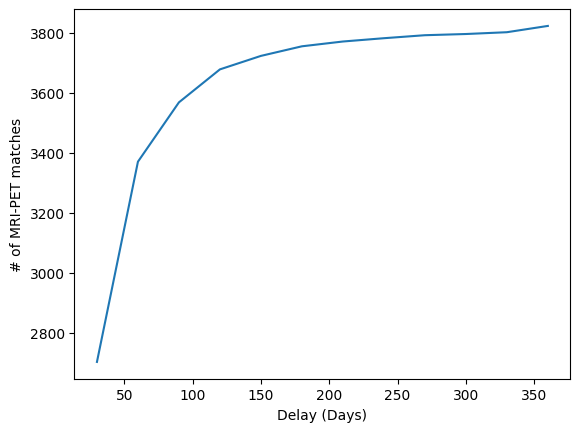

In [19]:
# Visualize empirical cumulative distribution of days difference between PET and MRI:

thresholds = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]

counts = [ (df_matched["days_diff"] <= t).sum() for t in thresholds]

plt.plot(thresholds, counts)
plt.xlabel("Delay (Days)")
plt.ylabel("# of MRI-PET matches")
plt.show()

In [20]:
# Save matched df to file
df_matched.to_csv("dataset.csv", index=False)

In [21]:
# Unique pet ids 
df_matched["pet_id"].unique()

array([ 1600825,  1600884,  1600939, ..., 11435581, 11498490, 11434648],
      shape=(4172,))

In [19]:
# unique mri ids
df_matched["mri_id"].unique()

array([  901027,  1234305,   240936, ..., 11394643, 11408860, 11427784],
      shape=(3696,))

In [20]:
# Print them in a string separated by commas, so it's downloadable from ADNI website
pet_ids = [ str(id) for id in df_matched["pet_id"].unique()]
print(len(pet_ids))
", ".join(pet_ids)

4172


'1600825, 1600884, 1600939, 1600964, 1600997, 1601016, 1601019, 1603475, 1594300, 1594303, 1602518, 1602519, 1596107, 1596111, 1596253, 1598926, 1598936, 1598957, 1598978, 1594566, 1594569, 1594517, 1594530, 1594546, 1594602, 1602284, 1602325, 1596160, 1596213, 1596222, 1596225, 1599382, 1599392, 1599450, 1599573, 1614323, 1598906, 1598909, 1598954, 1599005, 1600079, 1600102, 1600107, 1600126, 1600152, 1596560, 1596565, 1596589, 1596634, 1596660, 1613269, 1600592, 1597355, 1597357, 1597375, 1600321, 1598011, 1598096, 1598147, 1598181, 1598197, 1596536, 1596689, 1596694, 1620229, 1614445, 1601107, 1601108, 1601128, 1601196, 1601202, 1601248, 1601262, 1599049, 1599065, 1599085, 1620274, 1602516, 1602513, 1600841, 1600952, 1597435, 1601133, 1601165, 1601186, 1601210, 1601218, 1601237, 1601255, 1600907, 1600911, 1600919, 1620307, 1596104, 1596112, 1595779, 1595879, 1595913, 1610611, 1602503, 1602511, 1620351, 1600118, 1598103, 1596641, 1592037, 1592894, 1592897, 1592898, 1592899, 1592900, 

In [ ]:
mri_ids = [ str(id) for id in df_matched["mri_id"].unique()]

print(len(mri_ids))

", ".join(mri_ids)

3696


### Add file path

In [22]:
""" 
Once the scans have been preprocessed, add the filepaths to the csv
""" 

import pandas as pd 
import os

df = pd.read_csv("./dataset.csv")
df.head()

,pet_id,mri_id,diagnosis,ptid,days_diff
0,1600825,901027,3.0,127_S_1427,391
1,1600884,1234305,3.0,127_S_1427,7
2,1600939,901027,3.0,127_S_1427,2924
3,1600964,901027,3.0,127_S_1427,1112
4,1600997,901027,3.0,127_S_1427,1847


In [23]:
data_dir = os.path.abspath('./data')
mri_paths = [ os.path.join(data_dir, 'I'+str(id), 'clean_w_masked_mI'+str(id)+'.nii') 
             for id in df["mri_id"]]

pet_paths = [ os.path.join(data_dir, 'I'+str(id), 'clean_w_masked_rstatic_I'+str(id)+'.nii')
             for id in df["pet_id"]]

In [24]:
df["pet_path"] = pet_paths
df["mri_path"] = mri_paths

In [25]:
df.to_csv("./dataset.csv")